In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs, nsdiffs
import pmdarima as pm

In [2]:
df = pd.read_csv('exported_data.csv')
df

,ID,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
0,1326041,01/01/2001 01:00:00 AM,BATTERY,SIMPLE,RESIDENCE,False,False,1624,16.0,NaN,41.957850,-87.749185
1,1319931,01/01/2001 01:00:00 PM,BATTERY,SIMPLE,RESIDENCE,False,True,825,8.0,NaN,41.783892,-87.684841
2,1324743,01/01/2001 01:00:00 PM,GAMBLING,ILLEGAL ILL LOTTERY,STREET,True,False,313,3.0,NaN,41.780412,-87.611970
3,1310717,01/01/2001 01:00:00 AM,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2424,24.0,NaN,42.012391,-87.678032
4,1318099,01/01/2001 01:00:00 AM,BATTERY,SIMPLE,RESIDENCE PORCH/HALLWAY,False,True,214,2.0,NaN,41.819538,-87.620020
...,...,...,...,...,...,...,...,...,...,...,...,...
7713104,12938029,12/31/2022 12:50:00 PM,ASSAULT,SIMPLE,APARTMENT,False,False,1014,10.0,24.0,41.855911,-87.719966
7713105,12937822,12/31/2022 12:50:00 PM,ASSAULT,AGGRAVATED - HANDGUN,APARTMENT,False,True,733,7.0,6.0,41.766546,-87.645669
7713106,12937583,12/31/2022 12:52:00 AM,BATTERY,SIMPLE,BARBERSHOP,False,False,1135,11.0,28.0,41.868829,-87.686098
7713107,12938420,12/31/2022 12:52:00 PM,ASSAULT,SIMPLE,COMMERCIAL / BUSINESS OFFICE,False,False,1432,14.0,32.0,41.930693,-87.685657


In [3]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)



    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()
    
    return fig

In [4]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [6]:
#Date to datetime type
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y %I:%M:%S %p')

In [7]:
df

,ID,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
0,1326041,2001-01-01 01:00:00,BATTERY,SIMPLE,RESIDENCE,False,False,1624,16.0,NaN,41.957850,-87.749185
1,1319931,2001-01-01 13:00:00,BATTERY,SIMPLE,RESIDENCE,False,True,825,8.0,NaN,41.783892,-87.684841
2,1324743,2001-01-01 13:00:00,GAMBLING,ILLEGAL ILL LOTTERY,STREET,True,False,313,3.0,NaN,41.780412,-87.611970
3,1310717,2001-01-01 01:00:00,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2424,24.0,NaN,42.012391,-87.678032
4,1318099,2001-01-01 01:00:00,BATTERY,SIMPLE,RESIDENCE PORCH/HALLWAY,False,True,214,2.0,NaN,41.819538,-87.620020
...,...,...,...,...,...,...,...,...,...,...,...,...
7713104,12938029,2022-12-31 12:50:00,ASSAULT,SIMPLE,APARTMENT,False,False,1014,10.0,24.0,41.855911,-87.719966
7713105,12937822,2022-12-31 12:50:00,ASSAULT,AGGRAVATED - HANDGUN,APARTMENT,False,True,733,7.0,6.0,41.766546,-87.645669
7713106,12937583,2022-12-31 00:52:00,BATTERY,SIMPLE,BARBERSHOP,False,False,1135,11.0,28.0,41.868829,-87.686098
7713107,12938420,2022-12-31 12:52:00,ASSAULT,SIMPLE,COMMERCIAL / BUSINESS OFFICE,False,False,1432,14.0,32.0,41.930693,-87.685657


In [8]:
df = df.set_index('Date')

In [9]:
crimes = ['THEFT','BATTERY','NARCOTICS','ASSAULT']
subset = df[df['Primary Type'].isin(crimes)]

In [10]:
crime_sizes = subset.groupby('Primary Type').resample('MS').size()

## Theft

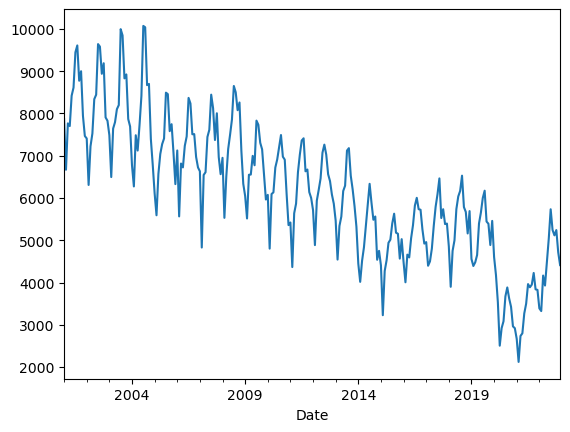

In [11]:
crime_sizes.loc['THEFT'].plot();

In [12]:
df_theft = df[df['Primary Type']== 'THEFT']
ts_theft = df_theft.resample('MS').size()
ts_theft.isnull().sum()

0

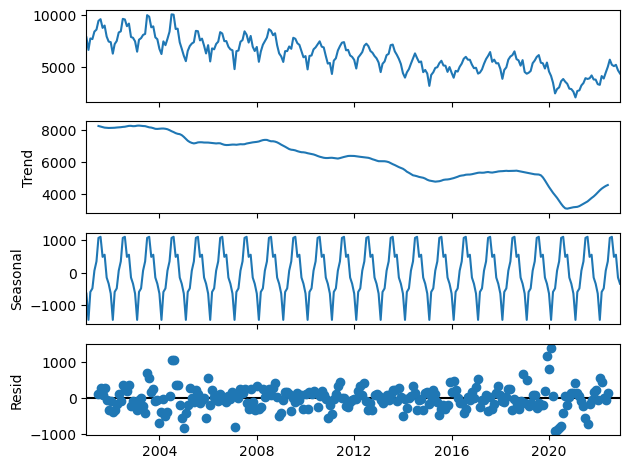

In [13]:
decomp_theft = tsa.seasonal_decompose(ts_theft)
decomp_theft.plot();

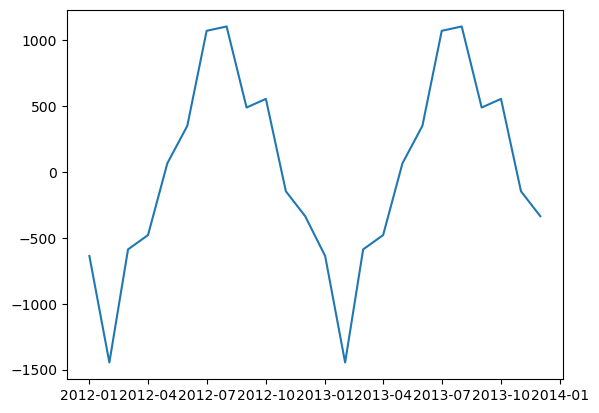

In [14]:
plt.plot(decomp_theft.seasonal.loc['2012':'2013'])

Yes seasonal, peaks in summer

In [15]:
d = ndiffs(ts_theft)
D = nsdiffs(ts_theft, m=12)

d,D

(1, 0)

In [16]:
ts_theft_diff = ts_theft.diff().dropna()

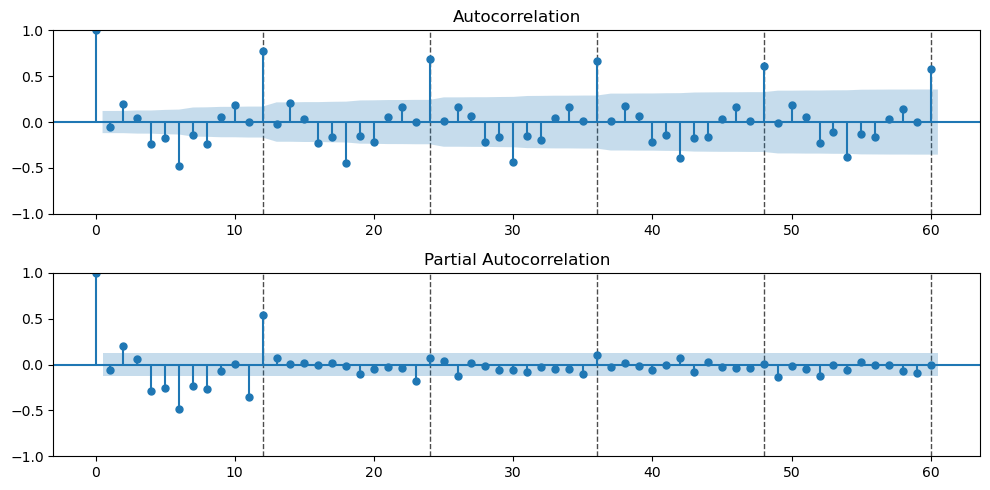

In [17]:
plot_acf_pacf(ts_theft_diff, m=12, pacf_kws={'method':'ywm'}, annotate_seas=True, nlags=60);

In [18]:
train, test = train_test_split(ts_theft, test_size=6)

In [19]:
p=1
d=1
q=1

P=1
D=0
Q=1
m=12

sarima = tsa.ARIMA(train, order=(p,d,q), seasonal_order=(P,D,Q, m)).fit()

In [20]:
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                                y   No. Observations:                  258
Model:             ARIMA(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -1874.387
Date:                          Sat, 02 Dec 2023   AIC                           3758.774
Time:                                  16:37:17   BIC                           3776.520
Sample:                              01-01-2001   HQIC                          3765.911
                                   - 06-01-2022                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9990      0.480      2.082      0.037       0.058       1.940
ma.L1         -0.9989      0.571     -1.748      0.080      -2.119       0.121
ar.S.L12       0.9712      0.009    110.786      0.000       0.954       0.988
ma.S.L12      -0.6651      0.045    -14.897      0.000      -0.753      -0.578
sigma2      1.129e+05   1.15e+04      9.778      0.000    9.02e+04    1.35e+05
===================================================================================
Ljung-Box (L1) (Q):                  10.95   Jarque-Bera (JB):                12.72
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                            -0.26
Prob(H) (two-sided):                  0.09   Kurtosis:                         3.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [22]:
sarima_forecast = sarima.get_forecast(steps=len(test)).summary_frame()

In [23]:
sarima_forecast['mean']

2022-07-01    5440.150790
2022-08-01    5543.199787
2022-09-01    5236.260952
2022-10-01    5271.050822
2022-11-01    4852.995407
2022-12-01    4954.174318
Freq: MS, Name: mean, dtype: float64

## First Model `Theft`

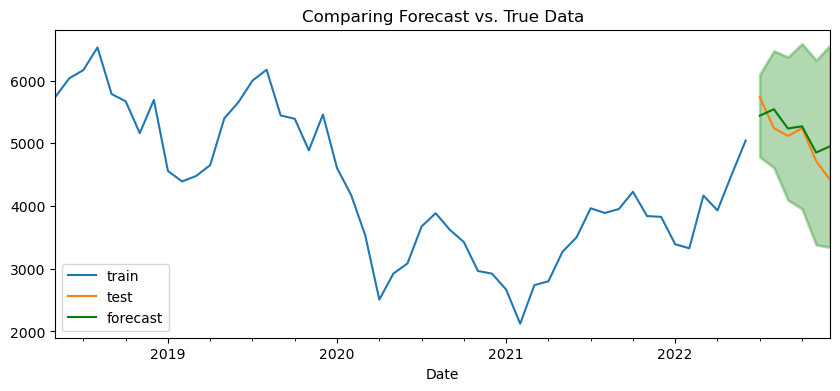

In [24]:
plot_forecast(train,test, sarima_forecast, n_train_lags=50);

In [25]:
regression_metrics_ts(test, sarima_forecast['mean'])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 236.422
- MSE = 83,716.565
- RMSE = 289.338
- R^2 = 0.526
- MAPE = 4.81%


Metrics. MAPE 4.81%

In [26]:
auto_model = pm.auto_arima(train, seasonal=True)
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  258
Model:               SARIMAX(5, 1, 3)   Log Likelihood               -1934.894
Date:                Sat, 02 Dec 2023   AIC                           3887.788
Time:                        16:37:25   BIC                           3919.730
Sample:                    01-01-2001   HQIC                          3900.634
                         - 06-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1060      0.081      1.303      0.193      -0.053       0.266
ar.L2          0.9361      0.080     11.697      0.000       0.779       1.093
ar.L3         -0.3489      0.096     -3.628      0.000      -0.537      -0.160
ar.L4         -0.4381      0.081     -5.437      0.000      -0.596      -0.280
ar.L5         -0.2528      0.075     -3.351      0.001      -0.401      -0.105
ma.L1         -0.7231      0.040    -18.146      0.000      -0.801      -0.645
ma.L2         -0.7459      0.036    -20.460      0.000      -0.817      -0.674
ma.L3          0.9366      0.042     22.243      0.000       0.854       1.019
sigma2      2.372e+05   2.45e+04      9.670      0.000    1.89e+05    2.85e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.63   Jarque-Bera (JB):                10.32
Prob(Q):                              0.43   Prob(JB):                         0.01
Heteroskedasticity (H):               0.64   Skew:                            -0.27
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
auto_model.order, auto_model.seasonal_order

((5, 1, 3), (0, 0, 0, 0))

In [28]:
auto_model_theft = tsa.ARIMA(train, order = auto_model.order).fit()

C:\Users\User\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\User\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [29]:
auto_model_theft_forecast = auto_model_theft.get_forecast(steps=len(test)).summary_frame()

## auto_model `Theft`

In [30]:
regression_metrics_ts(test, auto_model_theft_forecast['mean'])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 263.013
- MSE = 105,056.337
- RMSE = 324.124
- R^2 = 0.405
- MAPE = 5.13%


auto_model fit with MAPE 5.13%

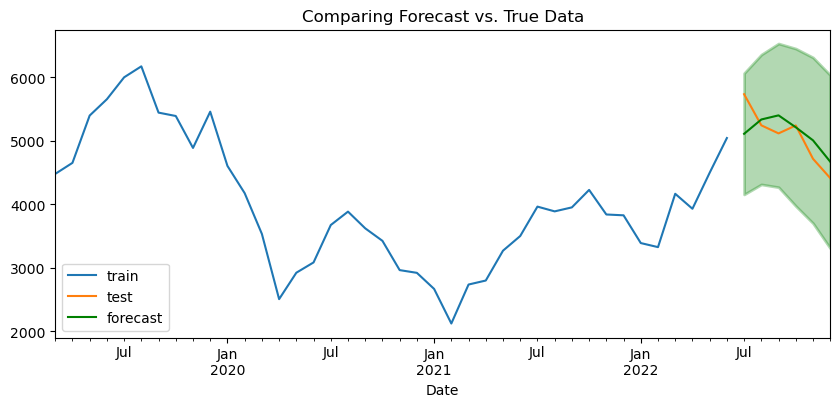

In [31]:
plot_forecast(train, test, auto_model_theft_forecast, n_train_lags=40);

The first model has a better visual fit and a lower MAPE, based off of that, I would say the first model is better.

## Narcotics

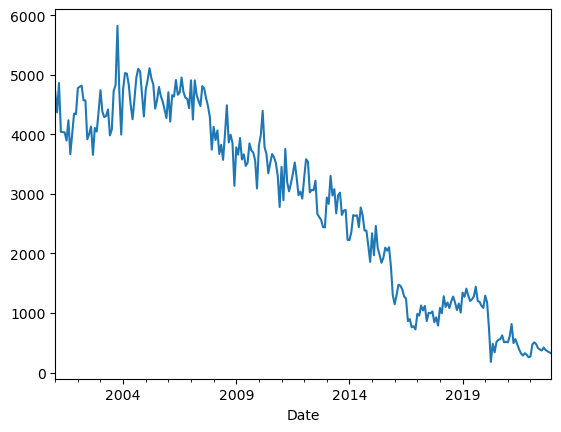

In [32]:
crime_sizes.loc['NARCOTICS'].plot();

In [33]:
df_narcs = df[df['Primary Type']== 'NARCOTICS']
ts_narcs = df_narcs.resample('MS').size()
ts_narcs.isnull().sum()

0

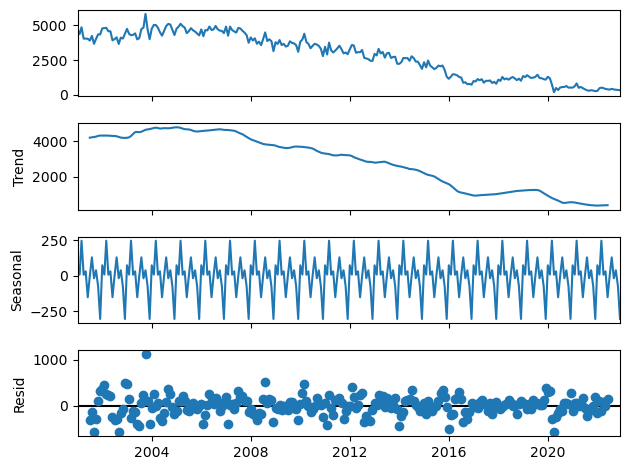

In [34]:
decomp_narcs = tsa.seasonal_decompose(ts_narcs)
decomp_narcs.plot();

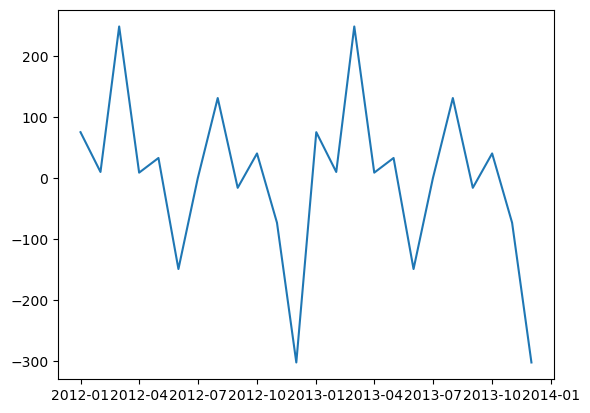

In [35]:
plt.plot(decomp_narcs.seasonal.loc['2012':'2013'])

Here the plot shows that the data is non seasonal.

In [36]:
d = ndiffs(ts_narcs)
D = nsdiffs(ts_narcs, m=12)

d, D

(1, 0)

In [37]:
# seasonal differencing not required.

In [38]:
ts_narcs_diff = ts_narcs.diff().dropna()

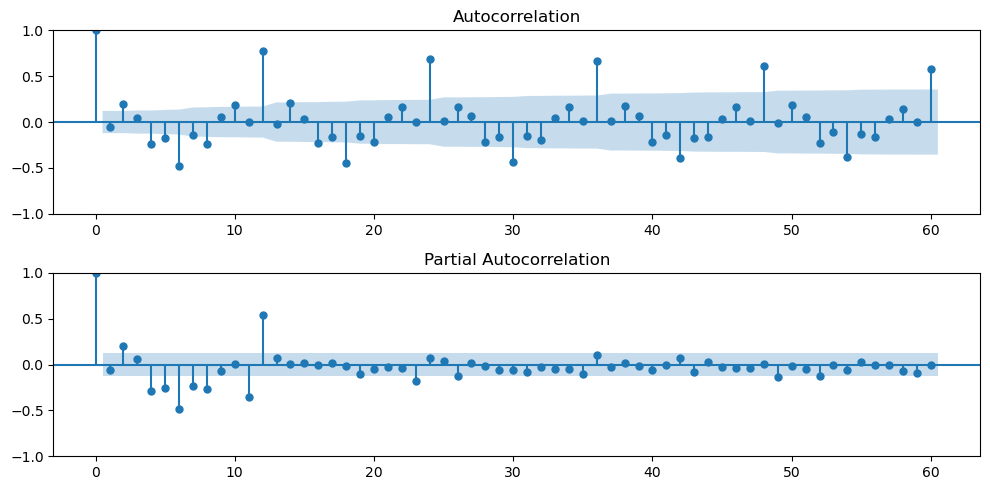

In [39]:
plot_acf_pacf(ts_theft_diff, pacf_kws={'method':'ywm'}, annotate_seas=False, nlags=60);

In [40]:
train, test = train_test_split(ts_narcs, test_size=6)

In [41]:
p=0
d=2
q=2


arima = tsa.ARIMA(train, order=(p,d,q)).fit()

In [42]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  258
Model:                 ARIMA(0, 2, 2)   Log Likelihood               -1811.793
Date:                Sat, 02 Dec 2023   AIC                           3629.586
Time:                        16:37:29   BIC                           3640.222
Sample:                    01-01-2001   HQIC                          3633.864
                         - 06-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.4468      3.119     -0.464      0.643      -7.559       4.665
ma.L2          0.4468      1.387      0.322      0.747      -2.271       3.165
sigma2      7.943e+04   2.48e+05      0.320      0.749   -4.07e+05    5.66e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.42   Jarque-Bera (JB):                15.38
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):               0.27   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [43]:
arima_forecast = arima.get_forecast(steps=len(test)).summary_frame()

In [44]:
arima_forecast['mean']

2022-07-01    381.064496
2022-08-01    365.465837
2022-09-01    349.867177
2022-10-01    334.268518
2022-11-01    318.669859
2022-12-01    303.071200
Freq: MS, Name: mean, dtype: float64

## First Model `Narcotics`

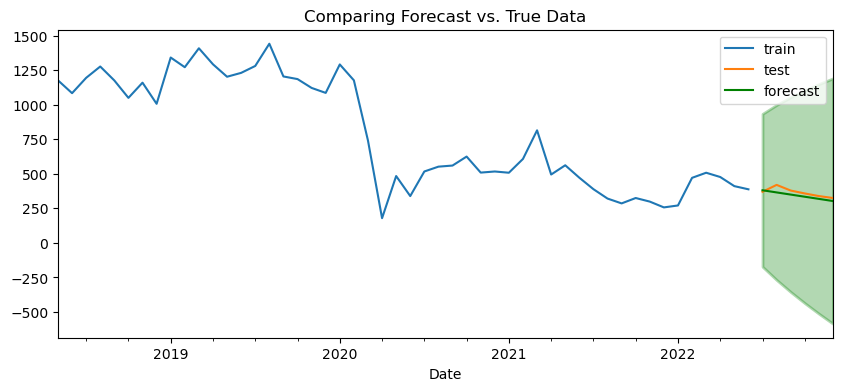

In [45]:
plot_forecast(train,test, arima_forecast, n_train_lags=50);

Plot seems to have a decent fit

In [46]:
regression_metrics_ts(test, arima_forecast['mean'])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 26.787
- MSE = 900.415
- RMSE = 30.007
- R^2 = 0.030
- MAPE = 7.17%


Metrics with MAPE 7.17%

In [47]:
auto_model2 = pm.auto_arima(train, seasonal=True)
auto_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  258
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1808.404
Date:                Sat, 02 Dec 2023   AIC                           3624.808
Time:                        16:37:31   BIC                           3639.005
Sample:                    01-01-2001   HQIC                          3630.517
                         - 06-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -9.6425      3.793     -2.543      0.011     -17.076      -2.209
ar.L1          0.3881      0.082      4.713      0.000       0.227       0.549
ma.L1         -0.8062      0.057    -14.139      0.000      -0.918      -0.694
sigma2      7.582e+04   5377.755     14.099      0.000    6.53e+04    8.64e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                21.57
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               0.30   Skew:                             0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [48]:
auto_model2.order, auto_model2.seasonal_order

((1, 1, 1), (0, 0, 0, 0))

In [49]:
auto_model_narcs = tsa.ARIMA(train, order = auto_model2.order).fit()

In [50]:
auto_model_narcs_forecast = auto_model_narcs.get_forecast(steps=len(test)).summary_frame()

In [51]:
regression_metrics_ts(test, auto_model_narcs_forecast['mean'])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 44.191
- MSE = 2,472.482
- RMSE = 49.724
- R^2 = -1.663
- MAPE = 12.67%


Metrics with MAPE 12.67%

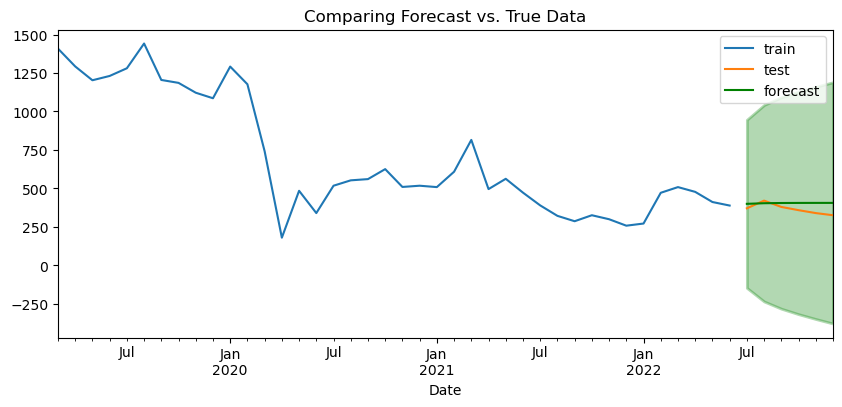

In [52]:
plot_forecast(train, test, auto_model_narcs_forecast, n_train_lags=40);

Visually does not show a great fit.

The first model was better according to metrics and visuals.

## Net Change/Percentage Change `Theft`

In [53]:
forecast_theft = sarima.get_forecast(steps=6).summary_frame()

In [54]:
forecast_theft

y,mean,mean_se,mean_ci_lower,mean_ci_upper
2022-07-01,5440.150790,335.955226,4781.690647,6098.610933
2022-08-01,5543.199787,475.126133,4611.969678,6474.429896
2022-09-01,5236.260952,581.925058,4095.708797,6376.813108
2022-10-01,5271.050822,671.968521,3954.016722,6588.084923
2022-11-01,4852.995407,751.305258,3380.464161,6325.526653
2022-12-01,4954.174318,823.037332,3341.050789,6567.297847


In [55]:
forecast_theft['mean'][-1] - forecast_theft['mean'][0]

-485.9764720477242

In [56]:
(-485.9764720477242 / forecast_theft['mean'][-1])*100

-9.809434243848072

## Net Change/Percentage Change `Narcotics`

In [58]:
forecast_narcs = arima.get_forecast(steps=6).summary_frame()
forecast_narcs

y,mean,mean_se,mean_ci_lower,mean_ci_upper
2022-07-01,381.064496,282.380182,-172.390490,934.519482
2022-08-01,365.465837,323.236317,-268.065703,998.997377
2022-09-01,349.867177,359.743158,-355.216455,1054.950810
2022-10-01,334.268518,393.114278,-436.221309,1104.758346
2022-11-01,318.669859,424.090563,-512.532370,1149.872089
2022-12-01,303.071200,453.163380,-585.112704,1191.255104


In [59]:
forecast_narcs['mean'][-1] - forecast_narcs['mean'][0]

-77.99329581937798

In [60]:
(-77.99329581937798 / forecast_narcs['mean'][-1])*100

-25.734314519524755

## Final Evaluation

- Theft is forecasted to have the higher amount of crimes. 
- Theft is forecasted to have the higher Net Change
- Narcotics is forecasted to have the higher Percentage Change.